In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project 1 Quora Question Pair/train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

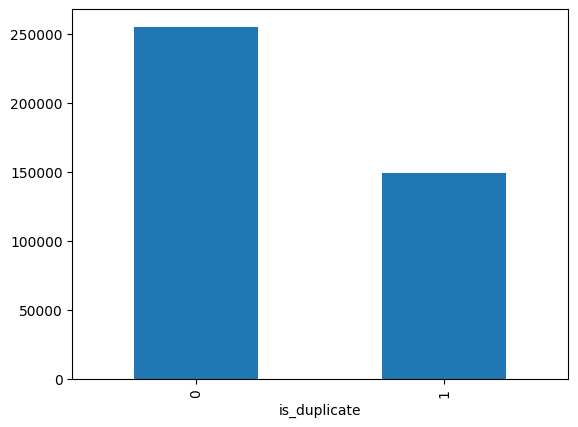

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print(f"Total Number Of question pairs for training are {len(df)}")

Total Number Of question pairs for training are 404290


In [ ]:
temp = round(df['is_duplicate'].mean()*100,2)
print(f"Questions which are not duplicate is duplicate = 0 is {temp} %")
temp = 100-temp
print(f"Questions which are not duplicate is duplicate = 1 is {temp} %")

Questions which are not duplicate is duplicate = 0 is 36.92 %
Questions which are not duplicate is duplicate = 1 is 63.08 %


## No. Of Unique Questions

In [ ]:
list1 = df['qid1'].tolist() + df['qid2'].tolist()
unique_qs = np.unique(list1)
len(unique_qs)
print(f"Total No. Of Unique Queestions are {len(unique_qs)}")

Total No. Of Unique Queestions are 537933


In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



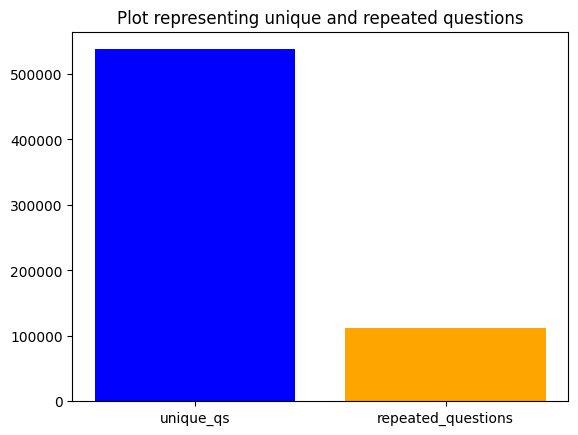

In [ ]:
import matplotlib.pyplot as plt

# Data
x = ["unique_qs", "repeated_questions"]
y = [unique_qs, qs_morethan_onetime]

# Create the bar plot
plt.bar(x, y,color=['blue', 'orange'])

# Add labels and title
#plt.xlabel("Classes")
#plt.ylabel("Length")
plt.title("Plot representing unique and repeated questions")

# Show the plot
plt.show()

## Check For Duplicate Rows

In [ ]:
temp_df = df.iloc[:,0:5]
temp_df.head()
duplicate_rows = temp_df.duplicated()
count_duplicates = duplicate_rows.sum()
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 0


Maximum number of times a single question is repeated: 157



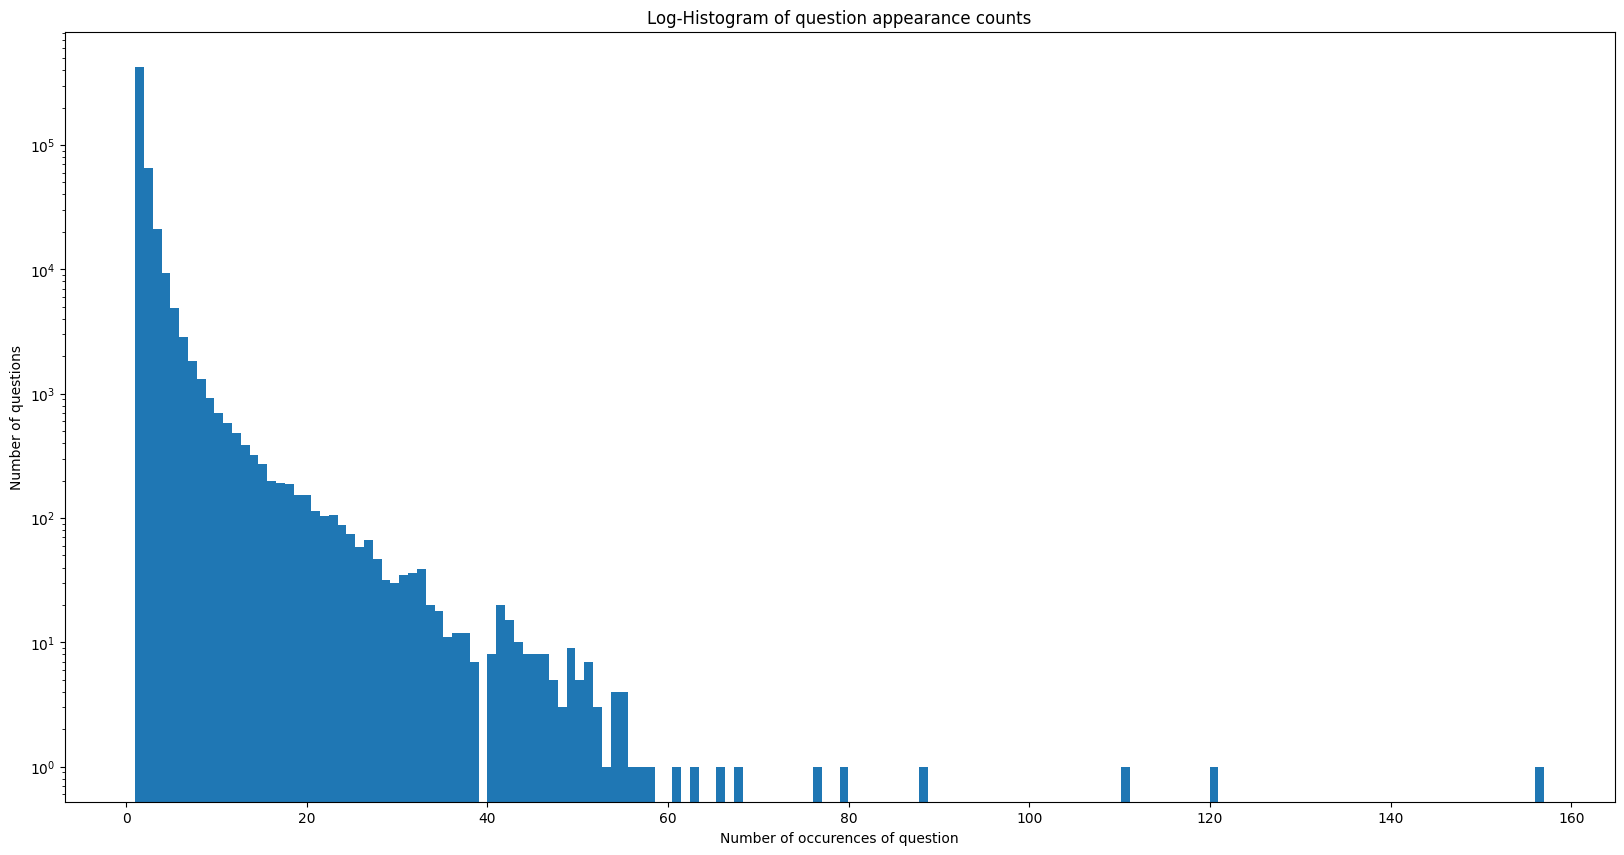

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


<ipython-input-17-ef527fb60746>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = df[df.isnull().any(1)]


In [ ]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<ipython-input-18-de06f25e882b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = df[df.isnull().any(1)]


# Basic Feature Extraction
### Let us now construct a few features like:

*   freq_qid1 = Frequency of qid1's

*   freq_qid2 = Frequency of qid2's

*   q1len = Length of q1

*   q2len = Length of q2
*   q1_n_words = Number of words in Question 1


*   q2_n_words = Number of words in Question 2


*   word_Common = (Number of common unique words in Question 1 and Question 2)


*   word_share = (word_common)/(word_Total)


*   freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

*   freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2


In [ ]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
def word_common(sentance1,sentance2):
  word_set1 = set(sentance1.split())
  word_set2 = set(sentance2.split())
  common = word_set1.intersection(word_set2)
  return len(common)
df['word_Common'] = df.apply(lambda row: word_common(row['question1'],row['question2']),axis=1)
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20.0,0.100000,4,2


In [ ]:
df.to_csv("df_fe_without_preprocessing_train.csv", index=False)



1.  Here are some questions have only one single words.





In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


## Distribution fo word share

<ipython-input-22-a8faaf34489a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
<ipython-input-22-a8faaf34489a>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label 

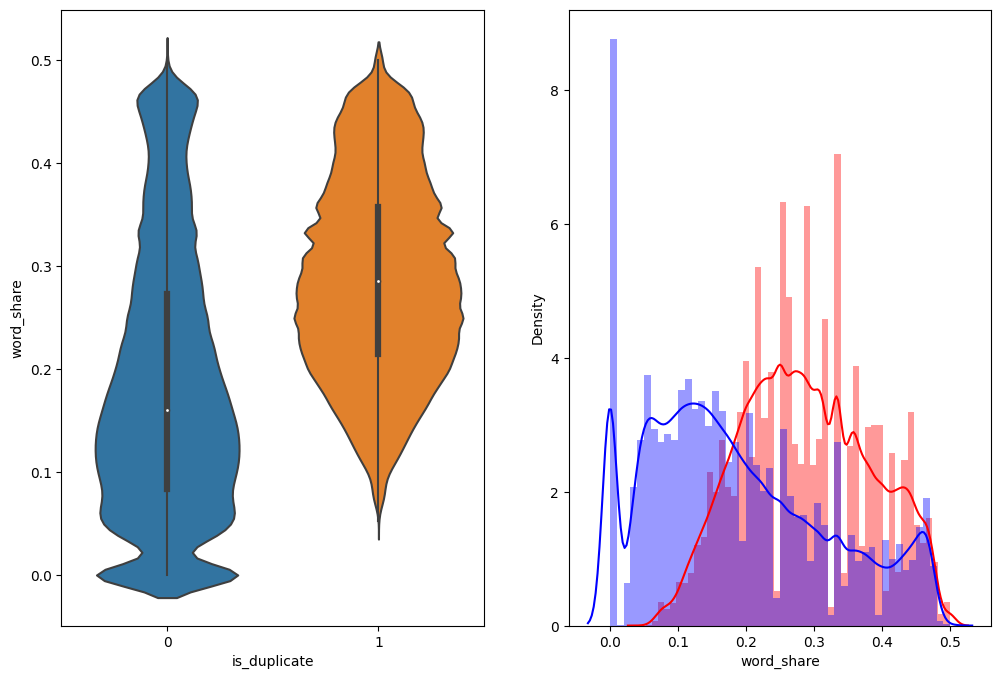

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()



*   The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
*   The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)



## Feature: word_Common

<ipython-input-23-bd5326372128>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
<ipython-input-23-bd5326372128>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , labe

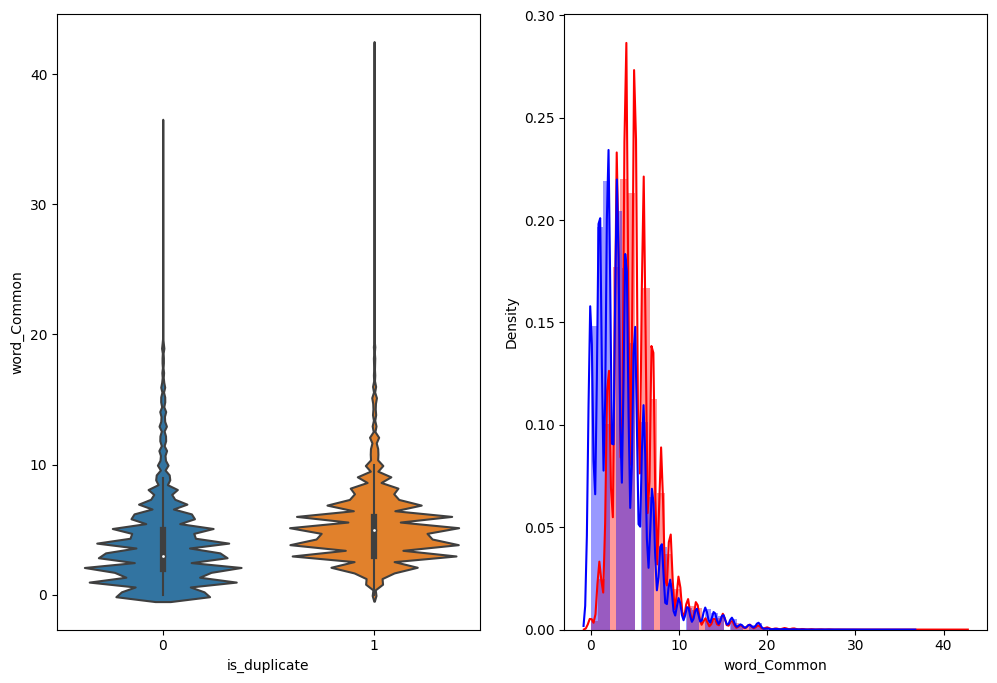

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

## Text Preprocessing

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words("english")
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [ ]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
df.head()

<ipython-input-25-d7458753c764>:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,11,9,0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2,20.0,0.100000,4,2


##Advance Feature Engineering

In [ ]:
# Advanced Features
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def fetch_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,...,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0


In [ ]:
# Fuzzy Features
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(df.shape)
df.head()

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


(404290, 29)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.999983,0.999983,0.916659,0.785709,0.0,1.0,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.749981,0.599988,0.699993,0.466664,0.0,1.0,66,74,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399992,0.249997,0.399996,0.285712,0.0,1.0,43,46,63,63
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,9,11,25,28
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.999950,0.666644,0.571420,0.307690,0.0,1.0,35,55,47,67


In [ ]:
def calculate_length_features(df, feature1_column, feature2_column):
    def get_length(sentence):
        # Tokenize the sentence and get the number of tokens
        tokens = sentence.split()
        return len(tokens)

    # Calculate absolute length difference and mean length
    df["abs_len_diff"] = df.apply(lambda row: abs(get_length(row[feature1_column]) - get_length(row[feature2_column])), axis=1)
    df["mean_len"] = df.apply(lambda row: (get_length(row[feature1_column]) + get_length(row[feature2_column])) / 2, axis=1)

    return df

# Call the function to calculate length features
df = calculate_length_features(df, feature1_column='question1', feature2_column='question2')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,abs_len_diff,mean_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,93,100,93,100,2,13.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,66,74,63,86,5,12.5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399996,0.285712,0.0,1.0,43,46,63,63,4,12.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,...,0.000000,0.000000,0.0,0.0,9,11,25,28,1,11.5
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.571420,0.307690,0.0,1.0,35,55,47,67,6,10.0


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,abs_len_diff,mean_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,93,100,93,100,2,13.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,66,74,63,86,5,12.5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399996,0.285712,0.0,1.0,43,46,63,63,4,12.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,...,0.000000,0.000000,0.0,0.0,9,11,25,28,1,11.5
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.571420,0.307690,0.0,1.0,35,55,47,67,6,10.0


In [ ]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16257 sha256=7c717b148d00ac7df78c4fffa40ae9c003198216c90902aa1131fecf5f9c5fde
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [ ]:
import distance
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,abs_len_diff,mean_len,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,93,100,93,100,2,13.0,0.982456
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,66,74,63,86,5,12.5,0.588235
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,43,46,63,63,4,12.0,0.169492
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,65,...,0.000000,0.0,0.0,9,11,25,28,1,11.5,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,35,55,47,67,6,10.0,0.153846


In [ ]:
df.to_csv("Final Features Data.csv")

## Plotting Word CLoud



*   Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
*   We can observe the most frequent occuring words



In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get the current working directory
current_dir = os.getcwd()

# File paths
file_path_p = os.path.join(current_dir, '/content/drive/MyDrive/Project 1 Quora Question Pair/train_p.txt')
file_path_n = os.path.join(current_dir, '/content/drive/MyDrive/Project 1 Quora Question Pair/train_n.txt')

# Read the files and remove stopwords
with open(file_path_p, 'r') as file_p, open(file_path_n, 'r') as file_n:
    textp_w = file_p.read()
    textn_w = file_n.read()

# Create a set of stopwords
stopwords_set = set(stopwords.words('english'))
custom_stopwords = ["said", "br", " ", "not", "no", "like"]
stopwords_set.update(custom_stopwords)

# Tokenize the text and remove stopwords
words_p = [word for word in word_tokenize(textp_w) if word.lower() not in stopwords_set]
words_n = [word for word in word_tokenize(textn_w) if word.lower() not in stopwords_set]

print("Total number of words in duplicate pair questions:", len(words_p))
print("Total number of words in non-duplicate pair questions:", len(words_n))

Total number of words in duplicate pair questions: 1446449
Total number of words in non-duplicate pair questions: 3039594


###__ Word Clouds generated from duplicate pair question's text __

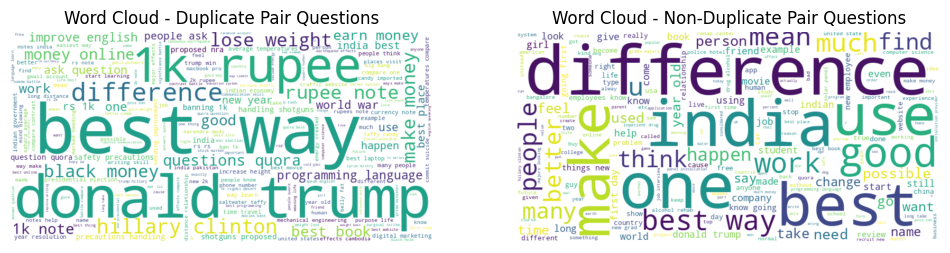

In [ ]:
# Convert lists of words to space-separated strings
textp_cleaned = " ".join(words_p)
textn_cleaned = " ".join(words_n)

# Create a WordCloud for duplicate pair questions
wordcloud_p = WordCloud(width=800, height=400, background_color='white').generate(textp_cleaned)

# Create a WordCloud for non-duplicate pair questions
wordcloud_n = WordCloud(width=800, height=400, background_color='white').generate(textn_cleaned)

# Display the word clouds using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_p, interpolation='bilinear')
plt.title("Word Cloud - Duplicate Pair Questions")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_n, interpolation='bilinear')
plt.title("Word Cloud - Non-Duplicate Pair Questions")
plt.axis("off")

plt.show()

## Some Pair Plots

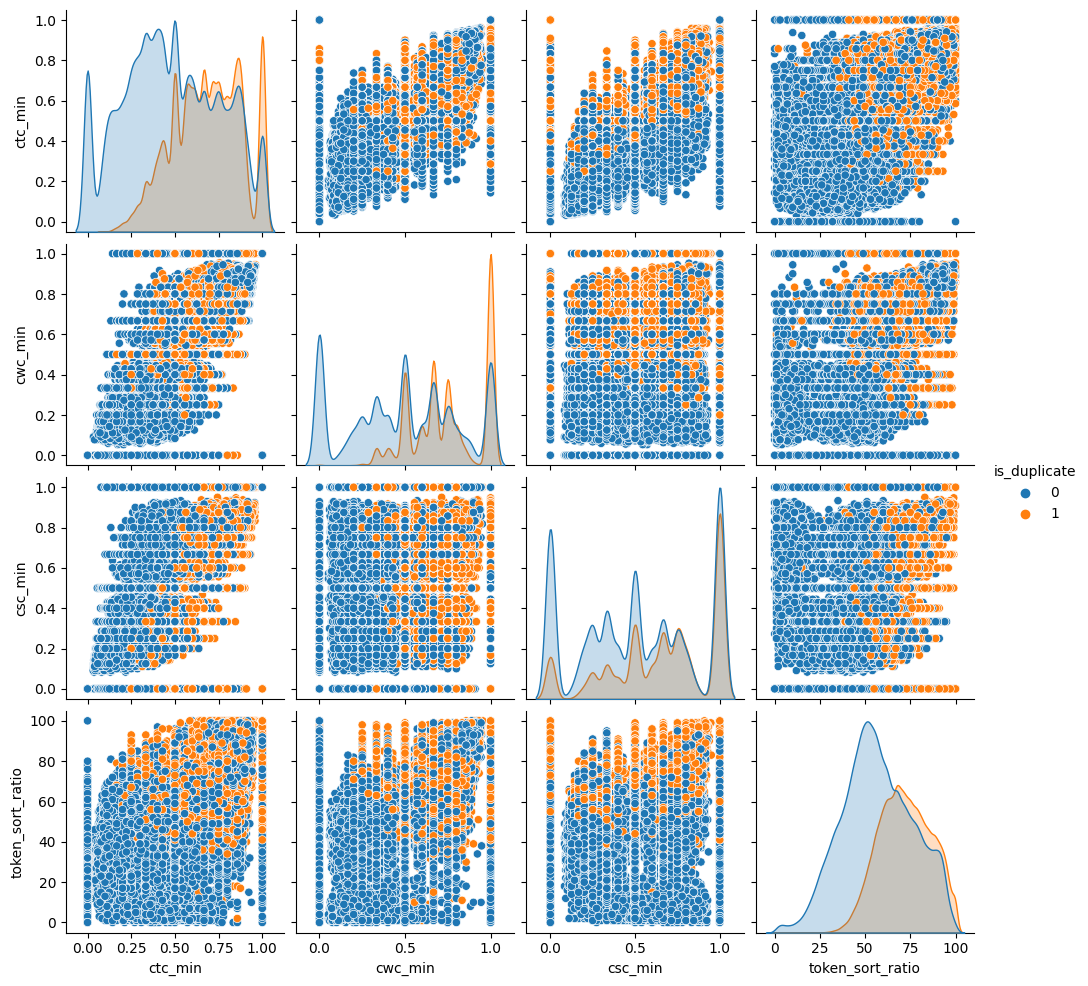

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

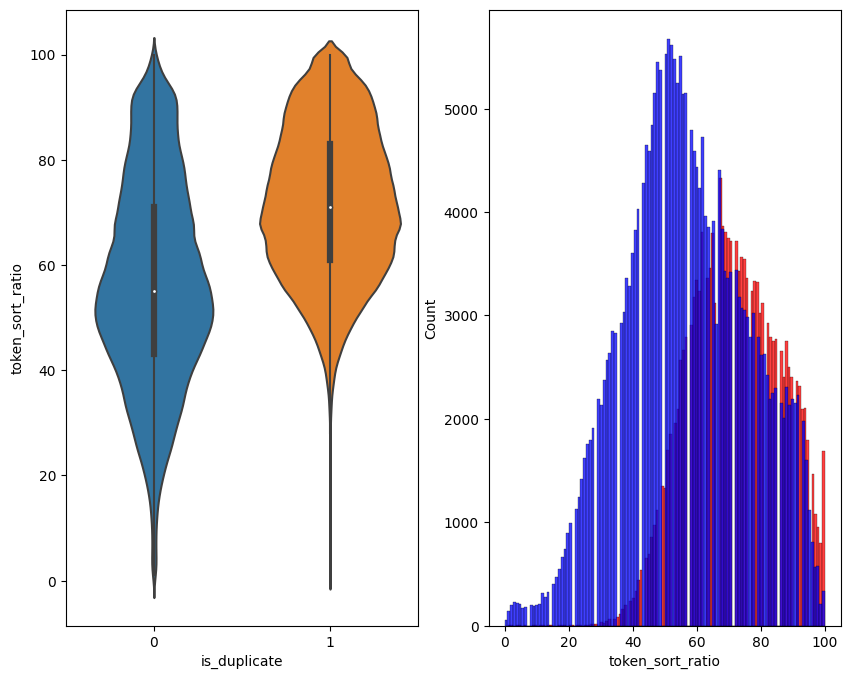

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

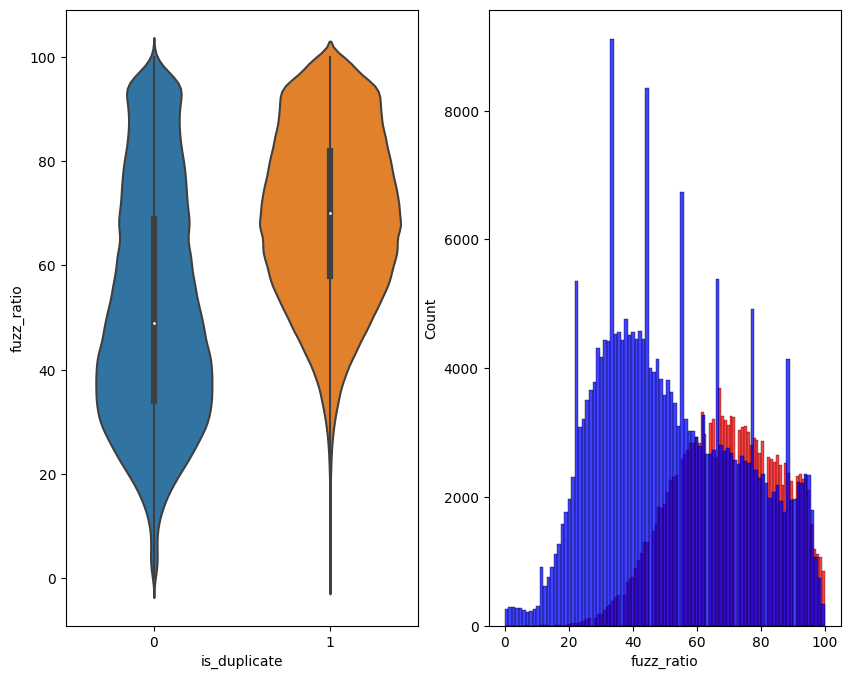

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## T-SNE

In [ ]:
new_df = pd.read_csv("/content/drive/MyDrive/Project 1 Quora Question Pair/Final Features Data.csv")
new_df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,abs_len_diff,mean_len,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.785709,0.0,1.0,93,100,93,100,2,13.0,0.982456
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,0.466664,0.0,1.0,66,74,63,86,5,12.5,0.588235
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,...,0.285712,0.0,1.0,43,46,63,63,4,12.0,0.169492
3,3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,1,1,50,...,0.000000,0.0,0.0,9,11,25,28,1,11.5,0.040000
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,...,0.307690,0.0,1.0,35,55,47,67,6,10.0,0.153846


In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130561
[t-SNE] Computed conditional probabilities in 0.137s
[t-SNE] Iteration 50: error = 85.5820236, gradient norm = 0.0837539 (50 iterations in 1.481s)
[t-SNE] Iteration 100: error = 70.9655609, gradient norm = 0.0130611 (50 iterations in 1.103s)
[t-SNE] Iteration 150: error = 69.0502853, gradient norm = 0.0075872 (50 iterations in 1.003s)
[t-SNE] Iteration 200: error = 68.1915131, gradient norm = 0.0055021 (50 iterations in 1.041s)
[t-SNE] Iteration 250: error = 67.6842270, gradient norm = 0.0044610

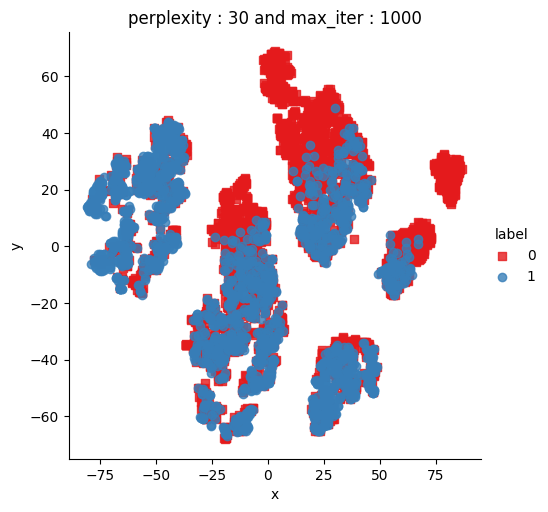

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130561
[t-SNE] Computed conditional probabilities in 0.269s
[t-SNE] Iteration 50: error = 86.4245377, gradient norm = 0.0821488 (50 iterations in 7.488s)
[t-SNE] Iteration 100: error = 69.6975403, gradient norm = 0.0072179 (50 iterations in 2.287s)
[t-SNE] Iteration 150: error = 68.0832367, gradient norm = 0.0036007 (50 iterations in 1.951s)
[t-SNE] Iteration 200: error = 67.4811172, gradient norm = 0.0024622 (50 iterations in 1.969s)
[t-SNE] Iteration 250: error = 67.1525421, gradient norm = 0.0019048

In [ ]:
# Assuming you have the 3D t-SNE embeddings stored in 'tsne3d'
# Replace 'tsne3d' with your actual 3D t-SNE embeddings

# Assuming 'y' contains the labels for each data point, specifying if it's a duplicate or not
# Replace 'y' with your actual labels

trace1 = go.Scatter3d(
    x=tsne3d[:, 0],
    y=tsne3d[:, 1],
    z=tsne3d[:, 2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color=y,
        colorscale='Portland',
        colorbar=dict(title='duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data = [trace1]
layout = dict(height=800, width=800, title='3D Embedding with Engineered Features')

fig = go.Figure(data=data, layout=layout)

# Save the figure as an HTML file (optional but useful to view later)
pio.write_html(fig, file='3d_scatter_plot.html', auto_open=True)

# Alternatively, display the figure in the Jupyter Notebook or web browser
fig.show()


## Spacy Large Model
 Taken a datasample of 30k points and then used word embedding of 100 d using spacy large model and then getting the final data set

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project 1 Quora Question Pair/Final_Training_Dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,212469,1,2,2,43,43,8,9,3,...,1.919219,-1.445276,-2.379048,1.715136,-1.413322,4.047420,0.885552,-0.029844,-2.853574,0.983803
1,1,128962,1,3,1,29,28,6,6,1,...,1.235348,-2.914298,3.090418,3.125790,-1.362555,1.083505,0.017552,-3.988321,-3.854939,3.125495
2,2,379207,0,1,2,56,74,11,15,2,...,1.192988,0.807766,0.695356,-0.158529,-0.551323,0.027814,0.490474,-0.891895,-3.309542,1.493484
3,3,291140,0,1,1,96,84,16,15,14,...,1.418039,0.395726,-0.891993,-1.114976,-2.709968,-0.763447,-0.216947,-2.005579,-2.975353,1.954145
4,4,87054,1,1,1,37,37,8,8,4,...,0.695627,-2.633376,2.272080,-0.348113,0.276252,0.894777,-1.650172,-0.105136,-3.641381,3.386103


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import numpy as np
import pandas as pd

<h1>4. Machine Learning Models </h1>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project 1 Quora Question Pair/Final_Training_Dataset.csv")
df.head()

,Unnamed: 0,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,212469,1,2,2,43,43,8,9,3,...,1.919219,-1.445276,-2.379048,1.715136,-1.413322,4.047420,0.885552,-0.029844,-2.853574,0.983803
1,1,128962,1,3,1,29,28,6,6,1,...,1.235348,-2.914298,3.090418,3.125790,-1.362555,1.083505,0.017552,-3.988321,-3.854939,3.125495
2,2,379207,0,1,2,56,74,11,15,2,...,1.192988,0.807766,0.695356,-0.158529,-0.551323,0.027814,0.490474,-0.891895,-3.309542,1.493484
3,3,291140,0,1,1,96,84,16,15,14,...,1.418039,0.395726,-0.891993,-1.114976,-2.709968,-0.763447,-0.216947,-2.005579,-2.975353,1.954145
4,4,87054,1,1,1,37,37,8,8,4,...,0.695627,-2.633376,2.272080,-0.348113,0.276252,0.894777,-1.650172,-0.105136,-3.641381,3.386103


In [ ]:
y_true = df['is_duplicate']
df.drop([ 'Unnamed: 0','id','is_duplicate'], axis=1, inplace=True)

In [ ]:
df.head()
data = df
data.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,2,2,43,43,8,9,3,17.0,0.176471,4,...,1.919219,-1.445276,-2.379048,1.715136,-1.413322,4.047420,0.885552,-0.029844,-2.853574,0.983803
1,3,1,29,28,6,6,1,12.0,0.083333,4,...,1.235348,-2.914298,3.090418,3.125790,-1.362555,1.083505,0.017552,-3.988321,-3.854939,3.125495
2,1,2,56,74,11,15,2,24.0,0.083333,3,...,1.192988,0.807766,0.695356,-0.158529,-0.551323,0.027814,0.490474,-0.891895,-3.309542,1.493484
3,1,1,96,84,16,15,14,31.0,0.451613,2,...,1.418039,0.395726,-0.891993,-1.114976,-2.709968,-0.763447,-0.216947,-2.005579,-2.975353,1.954145
4,1,1,37,37,8,8,4,16.0,0.250000,2,...,0.695627,-2.633376,2.272080,-0.348113,0.276252,0.894777,-1.650172,-0.105136,-3.641381,3.386103


<h2> 4.2 Converting strings to numerics </h2>

In [ ]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
fuzz_ratio
fuzz_partial_ratio
token_sort_ratio
token_set_ratio
abs_len_diff
mean_len
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [ ]:
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (21000, 626)
Number of data points in test data : (9000, 626)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6295714285714286 Class 1:  0.37042857142857144
---------- Distribution of output variable in train data ----------
Class 0:  0.37044444444444447 Class 1:  0.37044444444444447


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]
    plt.figure(figsize=(20,4))

    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

:<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8799539235773131


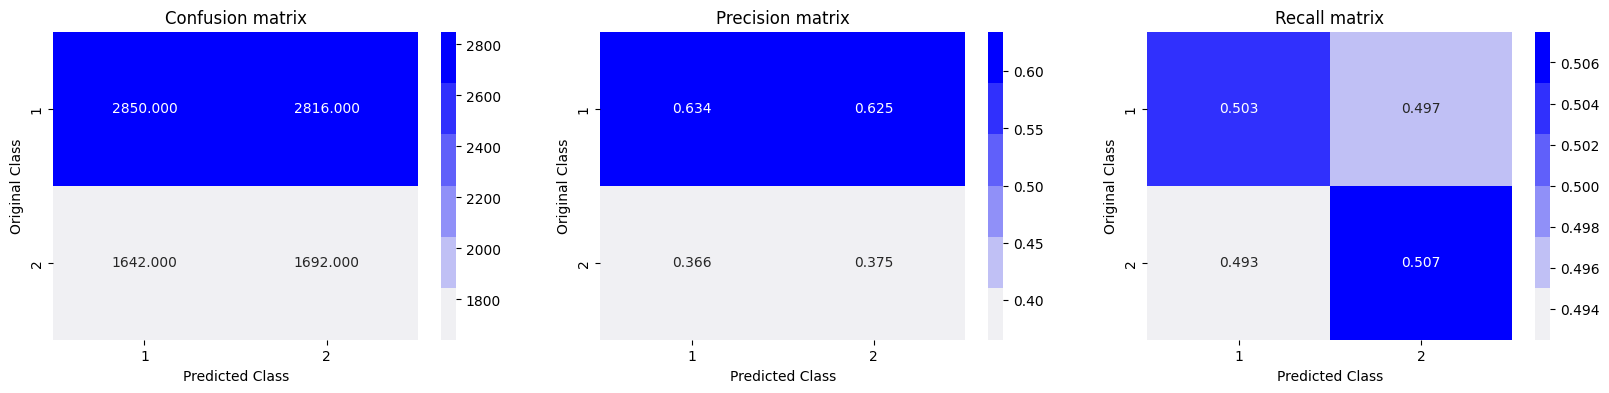

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.48301761373708124
For values of alpha =  0.0001 The log loss is: 0.47640618927303935
For values of alpha =  0.001 The log loss is: 0.4867698745383697
For values of alpha =  0.01 The log loss is: 0.4765906639590214
For values of alpha =  0.1 The log loss is: 0.49846684659486024
For values of alpha =  1 The log loss is: 0.5317857239012795
For values of alpha =  10 The log loss is: 0.5795332799483428


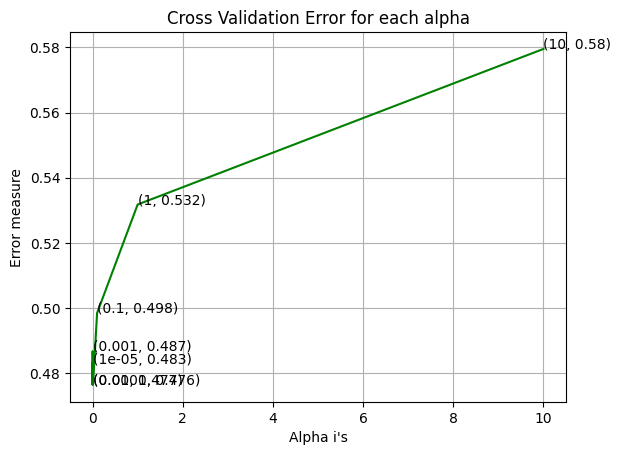

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

For values of best alpha =  0.0001 The train log loss is: 0.46901002252659896
For values of best alpha =  0.0001 The test log loss is: 0.47640618927303935
Total number of data points : 9000


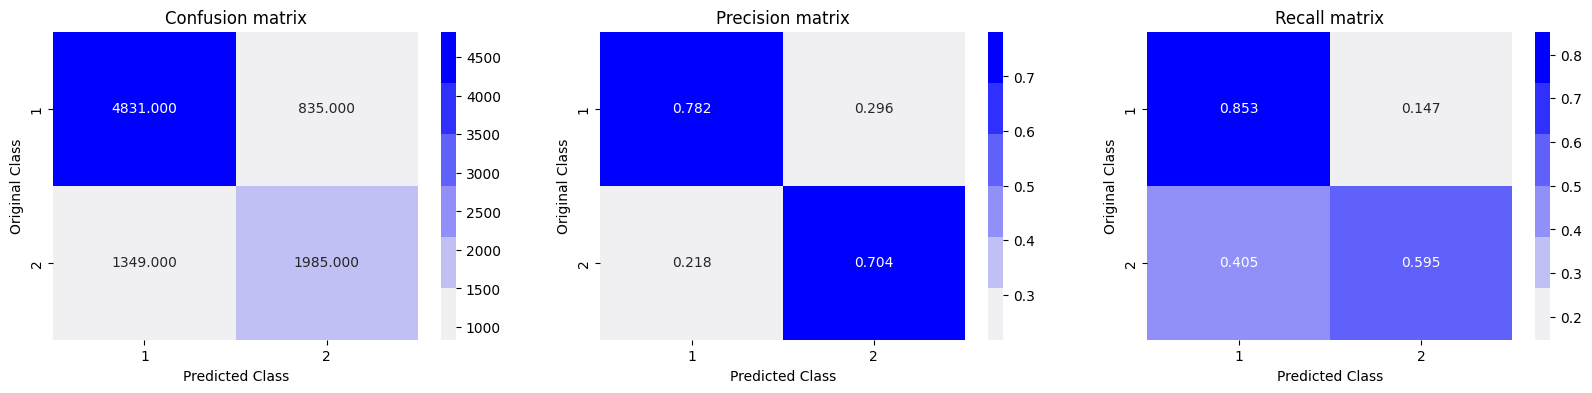

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link:
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4945242899069138
For values of alpha =  0.0001 The log loss is: 0.5073519367550066
For values of alpha =  0.001 The log loss is: 0.49782372626473415
For values of alpha =  0.01 The log loss is: 0.5050014235514066
For values of alpha =  0.1 The log loss is: 0.5680288565375046
For values of alpha =  1 The log loss is: 0.618366920465214
For values of alpha =  10 The log loss is: 0.6466602985869919


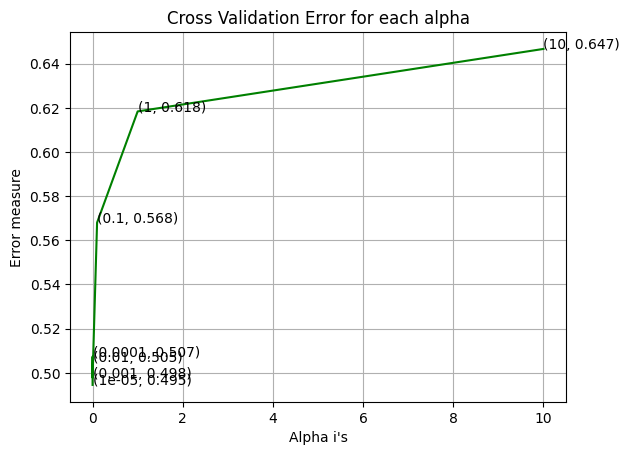

For values of best alpha =  1e-05 The train log loss is: 0.4863365850125617
For values of best alpha =  1e-05 The test log loss is: 0.4945242899069138
Total number of data points : 9000


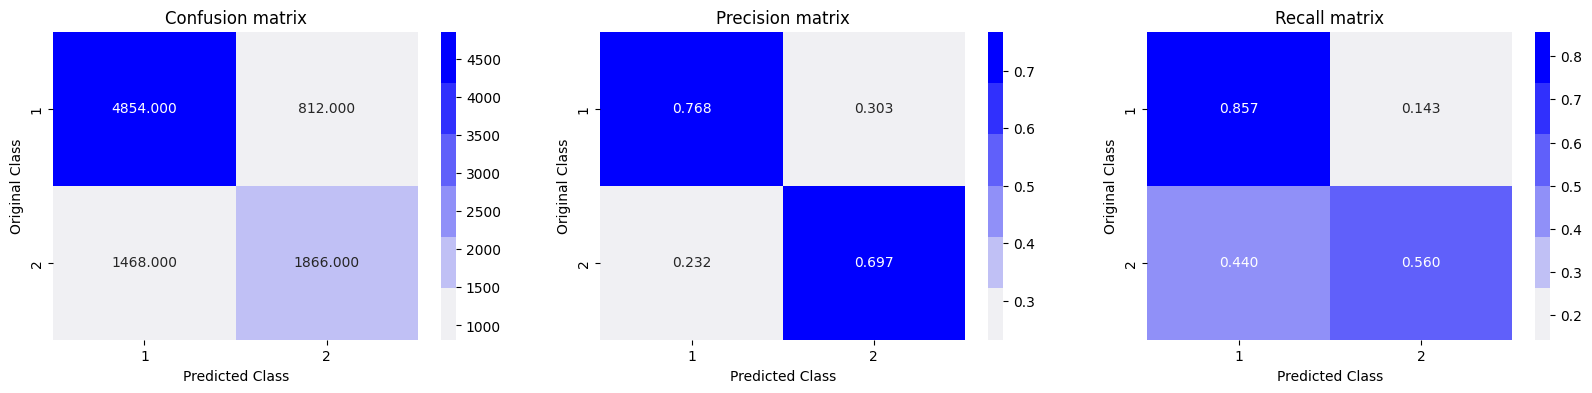

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link:
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.68613	valid-logloss:0.68615
[10]	train-logloss:0.62878	valid-logloss:0.62909
[20]	train-logloss:0.58738	valid-logloss:0.58777
[30]	train-logloss:0.55639	valid-logloss:0.55703
[40]	train-logloss:0.53248	valid-logloss:0.53363
[50]	train-logloss:0.51358	valid-logloss:0.51481
[60]	train-logloss:0.49805	valid-logloss:0.49974
[70]	train-logloss:0.48536	valid-logloss:0.48771
[80]	train-logloss:0.47504	valid-logloss:0.47767
[90]	train-logloss:0.46648	valid-logloss:0.46983
[100]	train-logloss:0.45925	valid-logloss:0.46326
[110]	train-logloss:0.45299	valid-logloss:0.45789
[120]	train-logloss:0.44753	valid-logloss:0.45332
[130]	train-logloss:0.44276	valid-logloss:0.44945
[140]	train-logloss:0.43846	valid-logloss:0.44607
[150]	train-logloss:0.43460	valid-logloss:0.44322
[160]	train-logloss:0.43106	valid-logloss:0.44081
[170]	train-logloss:0.42795	valid-logloss:0.43843
[180]	train-logloss:0.42512	valid-logloss:0.43621
[190]	train-logloss:0.42255	valid-logloss:0.43420
[200]	train

In [ ]:
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

The test log loss is: 0.41243828710681646


Total number of data points : 9000


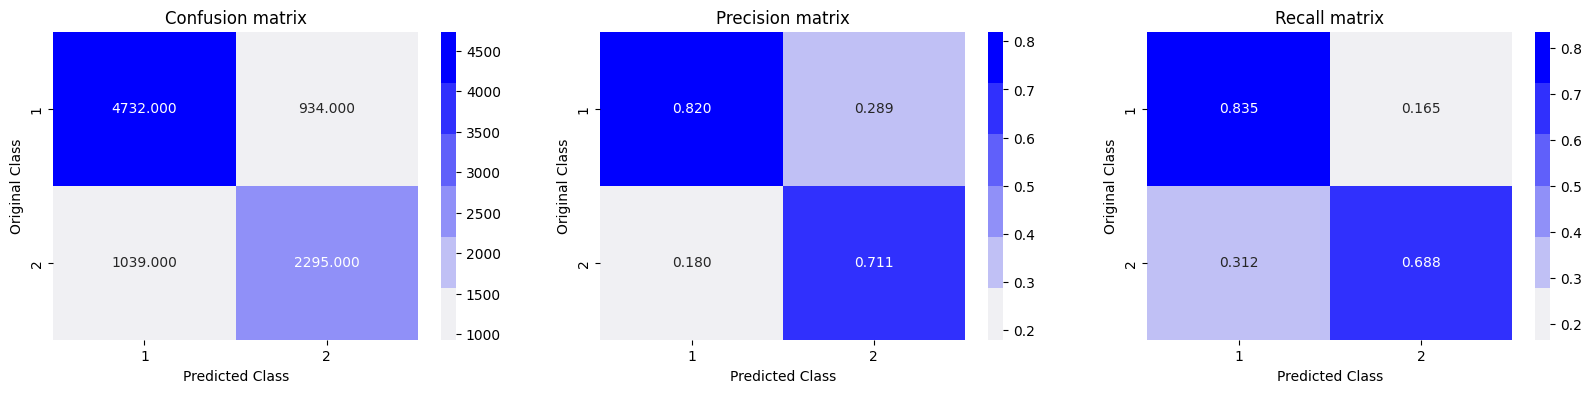

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
predict_y

array([0.0013939 , 0.53396076, 0.00981101, ..., 0.00713515, 0.05510102,
       0.6866759 ], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5
predict_y_binary = (predict_y > threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test, predict_y_binary)
f1 = f1_score(y_test, predict_y_binary)
precision = precision_score(y_test, predict_y_binary)
recall = recall_score(y_test, predict_y_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7808
F1 Score: 0.6994
Precision: 0.7107
Recall: 0.6884
